In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
import scipy as sp
import scib
import seaborn as sns
import anndata as ad

In [2]:
class RootCellError(Exception):
    def __init__(self, message):
        self.message = message

In [3]:
plt.rcParams["font.size"] = 10
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 15)
plt.rcParams.update({'axes.titlesize': 'x-large'})
sns.set(font_scale=1.5, style='white')
sns.set_context('poster')
sns.set(font_scale=1.5)
#sns.set_context("poster", rc={"axes.titlesize":20}) 
sns.set_style(style='white')
plt.rcParams["font.family"] = "sans-serif"
sns.set_palette(palette=sc.pl.palettes.godsnot_102)

In [4]:
def trajectory_conservation(
    adata_pre, adata_post, label_key, pseudotime_key="dpt_pseudotime", batch_key=None
):
    """Trajectory conservation score

    Trajectory conservation is measured by  spearman’s rank correlation coefficient :math:`s`, between the pseudotime
    values before and after integration.
    The final score was scaled to a value between 0 and 1 using the equation

     .. math::

        trajectory \\, conservation = \\frac {s + 1} {2}

    :param adata_pre: unintegrated adata
    :param adata_post: integrated adata
    :param label_key: column in ``adata_pre.obs`` of the groups used to precompute the trajectory
    :param pseudotime_key: column in ``adata_pre.obs`` in which the pseudotime is saved in.
        Column can contain empty entries, the dataset will be subset to the cells with scores.
    :param batch_key: set to batch key if you want to compute the trajectory metric by batch. By default the batch
        information will be ignored (``batch_key=None``)

    This function requires pseudotime values in ``.obs`` of the unintegrated object (``adata_pre``) computed per batch
    and can be applied to all integration output types.
    The input trajectories should be curated manually as the quality of the metric depends on the quality of the metric
    depends on the quality of the annotation.
    The integrated object (``adata_post``) needs to have a kNN graph based on the integration output.
    See :ref:`preprocessing` for more information on preprocessing.

    **Examples**

    .. code-block:: python

        # feature output
        scib.pp.reduce_data(
            adata, n_top_genes=2000, batch_key="batch", pca=True, neighbors=True
        )
        scib.me.trajectory_conservation(adata_unintegrated, adata, label_key="cell_type")

        # embedding output
        sc.pp.neighbors(adata, use_rep="X_emb")
        scib.me.trajectory_conservation(adata_unintegrated, adata, label_key="celltype")

        # knn output
        scib.me.trajectory_conservation(adata_unintegrated, adata, label_key="celltype")

    """
    # subset to cells for which pseudotime has been computed
    cell_subset = adata_pre.obs.index[adata_pre.obs[pseudotime_key].notnull()]
    adata_pre_ti = adata_pre[cell_subset]
    adata_post_ti = adata_post[cell_subset]
    try:
        iroot, adata_post_ti2 = get_root(
            adata_pre_ti, adata_post_ti, label_key, pseudotime_key
        )
    except RootCellError:
        print("No root cell found, setting trajectory conservation metric to 0.")
        return 0  # failure to find root cell means no TI conservation
    #print(iroot)
    adata_post_ti2.uns["iroot"] = iroot

    sc.tl.dpt(adata_post_ti2)  # stored in 'dpt_pseudotime'
    adata_post_ti2.obs.loc[
        adata_post_ti2.obs["dpt_pseudotime"] > 1, "dpt_pseudotime"
    ] = 0
    adata_post_ti.obs["dpt_pseudotime"] = 0
    adata_post_ti.obs["dpt_pseudotime"] = adata_post_ti2.obs["dpt_pseudotime"]
    adata_post_ti.obs["dpt_pseudotime"].fillna(0, inplace=True)

    if batch_key is None:
        pseudotime_before = adata_pre_ti.obs[pseudotime_key]
        pseudotime_after = adata_post_ti.obs["dpt_pseudotime"]
        correlation = pseudotime_before.corr(pseudotime_after, "spearman")
        return (correlation + 1) / 2  # scaled
    else:
        check_batch(batch_key, adata_pre.obs)
        check_batch(batch_key, adata_post.obs)

        # check if batches match
        if not np.array_equal(
            adata_post_ti.obs[batch_key], adata_pre_ti.obs[batch_key]
        ):
            raise ValueError(
                "Batch columns do not match\n"
                f"adata_post_ti.obs['batch']:\n {adata_post_ti.obs[batch_key]}\n"
                f"adata_pre_ti.obs['batch']:\n {adata_pre_ti.obs[batch_key]}\n"
            )

        corr = pd.Series()
        for i in adata_pre_ti.obs[batch_key].unique():
            pseudotime_before = adata_pre_ti.obs[adata_pre_ti.obs[batch_key] == i][
                pseudotime_key
            ]
            pseudotime_after = adata_post_ti.obs[adata_post_ti.obs[batch_key] == i][
                "dpt_pseudotime"
            ]
            corr[i] = pseudotime_before.corr(pseudotime_after, "spearman")

        return (corr.mean() + 1) / 2  # scaled


def get_root(adata_pre, adata_post, ct_key, pseudotime_key="dpt_pseudotime", dpt_dim=3):
    """Determine root cell for integrated adata based on unintegrated adata

    :param adata_pre: unintegrated adata
    :param adata_post: integrated adata
    :param label_key: column in ``adata_pre.obs`` of the groups used to precompute the trajectory
    :param pseudotime_key: column in ``adata_pre.obs`` in which the pseudotime is saved in.
        Column can contain empty entries, the dataset will be subset to the cells with scores.
    :param dpt_dim: number of diffmap dimensions used to determine root
    """
    n_components, adata_post.obs["neighborhood"] = connected_components(
        csgraph=adata_post.obsp["connectivities"], directed=False, return_labels=True
    )

    #start_clust = adata_pre.obs.groupby([ct_key],observed=True).mean()[pseudotime_key].idxmin()
    start_clust = adata_pre.obs.groupby([ct_key],observed=True)[pseudotime_key].mean().idxmin()
    #print(start_clust)
    #print(adata_post.obs["neighborhood"].unique())
    #print(adata_post.obs["neighborhood"].value_counts().idxmax())
    min_dpt = adata_pre.obs[adata_pre.obs[ct_key] == start_clust].index
    which_max_neigh = (
        adata_post.obs["neighborhood"]
        == adata_post.obs["neighborhood"].value_counts().idxmax()
    )
    #print(which_max_neigh.unique())
    min_dpt = [
        value for value in min_dpt if value in adata_post.obs[which_max_neigh].index
    ]

    adata_post_ti = adata_post[which_max_neigh]

    min_dpt = [adata_post_ti.obs_names.get_loc(i) for i in min_dpt]
    
    # compute Diffmap for adata_post
    sc.tl.diffmap(adata_post_ti)

    # determine most extreme cell in adata_post Diffmap
    min_dpt_cell = np.zeros(len(min_dpt))
    for dim in np.arange(dpt_dim):

        diffmap_mean = adata_post_ti.obsm["X_diffmap"][:, dim].mean()
        diffmap_min_dpt = adata_post_ti.obsm["X_diffmap"][min_dpt, dim]

        # count opt cell
        if len(diffmap_min_dpt) == 0:
            raise RootCellError("No root cell in largest component")
            #continue

        # choose optimum function
        if len(diffmap_min_dpt) > 0 and diffmap_min_dpt.mean() < diffmap_mean:
            opt = np.argmin
        else:
            opt = np.argmax

        min_dpt_cell[opt(diffmap_min_dpt)] += 1

    # root cell is cell with max vote
    return min_dpt[np.argmax(min_dpt_cell)], adata_post_ti

In [5]:
from scipy.sparse.csgraph import connected_components

def run_pp(adata, adata_int, type_, changeCT = False):
    # DATA REDUCTION
    # select options according to type
    
    if changeCT:
        adata.obs.loc[adata.obs.final_annotation == 'Lymphocyte progenitors', 'final_annotation'] = 'HSPCs'
        adata_int.obs.loc[adata_int.obs.final_annotation == 'Lymphocyte progenitors', 'final_annotation'] = 'HSPCs'
        
    if len(set(adata.obs_names).difference(set(adata_int.obs_names))) > 0:
        #rename adata_int.obs[batch_key] labels by overwriting them with the pre-integration labels
        #new_obs_names = ['-'.join(idx.split('-')[:-1]) for idx in adata_int.obs_names]

        if len(set(adata.obs_names).difference(set(new_obs_names))) == 0:
            adata_int.obs_names = new_obs_names
        else:
            print(set(adata.obs_names).difference(set(new_obs_names)))
            raise ValueError('obs_names changed after integration!')
    
    if adata.n_vars > adata_int.n_vars:
        n_hvgs = None
    
    # case 1: full expression matrix, default settings
    precompute_pca = True
    recompute_neighbors = True
    embed = 'X_pca'
    n_hvgs=2000
    #n_hvgs=15
    
    # distinguish between subsetted and full expression matrix
    # compute HVGs only if output is not already subsetted
    if adata.n_vars > adata_int.n_vars:
        n_hvgs = None
    
    # case 2: embedding output
    if (type_ == "embed"):
        n_hvgs = 10    #change to 15
        embed = "X_emb"
        # legacy check
        if ('emb' in adata_int.uns) and (adata_int.uns['emb']):
            adata_int.obsm["X_emb"] = adata_int.obsm["X_pca"].copy()
    
    # case3: kNN graph output
    elif (type_ == "graph"):
        n_hvgs = None
        precompute_pca = False
        recompute_neighbors = False
    
    sc.pp.filter_genes(adata_int, min_cells=1)
    scib.preprocessing.reduce_data(adata_int,
                                   n_top_genes=n_hvgs,
                                   neighbors=recompute_neighbors, use_rep=embed,
                                   pca=precompute_pca, umap=False)

def trajectory_plot(adata_pre, adata_post, label_key, type_, changeCT=False):
    #if len(set(adata_pre.obs_names).difference(set(adata_post.obs_names))) > 0:
        #rename adata_int.obs[batch_key] labels by overwriting them with the pre-integration labels
        #new_obs_names = ['-'.join(idx.split('-')[:-1]) for idx in adata_post.obs_names]
        #new_obs_names = adata_post.obs_names.str[-2]

        #if len(set(adata_pre.obs_names).difference(set(new_obs_names))) == 0:
            #adata_post.obs_names = new_obs_names
        #else:
        #    #print((set(adata_pre.obs_names).difference(set(new_obs_names))))
        #    print(new_obs_names[:10])
        #    raise ValueError('obs_names changed after integration!')
    adata_post.obs_names = adata_pre.obs_names
    #run_pp(adata_pre, adata_post, type_, changeCT=changeCT)
    
    cell_subset = adata_pre.obs.index[adata_pre.obs["dpt_pseudotime"].notnull()]
    adata_pre_sub = adata_pre[cell_subset]
    adata_post_sub = adata_post[cell_subset]
    
    iroot, adata_post_sub2 = get_root(adata_pre_sub, adata_post_sub, label_key)
    adata_post_sub2.uns["iroot"] = iroot
    if adata_post_sub2:
        sc.tl.dpt(adata_post_sub2)
        #adata_post_sub.obs['dpt_pseudotime'][adata_post_sub.obs['dpt_pseudotime']>1]=0
        #return (adata_post_sub.obs['dpt_pseudotime'].corr(adata_pre_sub.obs['dpt_pseudotime'], 'spearman')+1)/2
        #adata_pre_sub.obs['dpt_after'] = adata_post_sub.obs['dpt_pseudotime']
    
        adata_post_sub.obs['dpt_after'] = pd.Series(range(len(adata_post_sub2.obs)), index=adata_post_sub2.obs.sort_values('dpt_pseudotime').index)
    else:
        adata_post_sub.obs['dpt_after'] = 0
        #adata_post_wo = adata_post_sub[adata_post_sub.obs.dpt_pseudotime!=0]
    """if 'conos' in label:
            sc.tl.draw_graph(adata_post_sub)
            sc.pl.umap(adata_post_sub, color='dpt_after', title=label, show=False, frameon=False, ax=ax)
        else:    
            #sc.tl.umap(adata_post_sub)
            #sc.pl.umap(adata_post_sub, color='dpt_after', title=label, show=False, frameon=False, ax=ax)

    else:
        #adata_pre_draw.obs['dpt_after'] = pd.Series(range(len(adata_pre_draw.obs)), index=adata_post_sub.obs.sort_values('dpt_pseudotime').index)
        #sc.tl.umap(adata_pre_draw)
        #sc.pl.umap(adata_pre_draw, color='dpt_after', title=label, show=False, frameon=False, ax=ax)"""
    return adata_pre_sub, adata_post_sub

In [8]:
emb=sc.read_h5ad('/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/scMDC-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
rna=sc.read_h5ad('/mnt/nas/user/yixuan/Multiomics-benchmark-main/data/download/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-RNA_fake.h5ad')
sc.pp.pca(rna)
sc.pp.neighbors(rna)
indices = np.where(np.array(rna.obs['cell_type'] == "HSPC"))[0]
    #rna.uns["iroot"] = np.random.choice(indices)
id=4
rna.uns["iroot"] = indices[id]
print(indices)
#rna.uns["iroot"] = 0
sc.tl.diffmap(rna)
sc.tl.dpt(rna)
    #  
sc.pp.pca(emb)
sc.pp.neighbors(emb)

score = trajectory_conservation(
        adata_pre=rna,
        adata_post=emb,
        label_key="cell_type",
        pseudotime_key="dpt_pseudotime",
    )

print(score)

KeyError: 'diffmap_evals'

In [6]:
rna=ad.read_h5ad('/mnt/nas/user/yixuan/Multiomics-benchmark-main/data/download/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-RNA.h5ad')
print(rna)
emb=pd.read_csv('/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/scGPT-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-smallbc-rna.csv',header=None,index_col=0)
# emb=pd.read_csv('/data2/wangxuesong/benchmark_data/benchmark_embedding/10x-Multiome-Pbmc10k-small/scJoint_rna.csv',header=None,index_col=0)

emb_rna=ad.AnnData(emb.values,obs=rna.obs)

sc.pp.pca(rna)
sc.pp.neighbors(rna)
indices = np.where(np.array(rna.obs['cell_type'] == "HSPC"))[0]
    #rna.uns["iroot"] = np.random.choice(indices)
rna.uns["iroot"] = indices[1]
print(indices)
#rna.uns["iroot"] = 0
sc.tl.diffmap(rna)
sc.tl.dpt(rna)
    #  
sc.pp.pca(emb_rna)
sc.pp.neighbors(emb_rna)
    #emb_rna.uns["iroot"] = 0
    #sc.tl.dpt(emb_rna)
    #sc.tl.diffmap(emb_rna)
    
score = trajectory_conservation(
        adata_pre=rna,
        adata_post=emb_rna,
        label_key="cell_type",
        pseudotime_key="dpt_pseudotime",
    )

print(score)

AnnData object with n_obs × n_vars = 9631 × 8000
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'tag', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'
[ 508 2744 4227 4291 5419 6365 6685 7487 7852 7891 7974 8218 8340 8966
 9139 9442 9462]
0.48331435888094154


In [7]:
emb_rna.n_vars

64

In [8]:
rna.obs['cell_type']

cells
AAACAGCCAATCCCTT-1      CD4 TCM
AAACAGCCAATGCGCT-1    CD4 Naive
AAACAGCCACCAACCG-1    CD8 Naive
AAACAGCCAGGATAAC-1    CD4 Naive
AAACAGCCAGTTTACG-1      CD4 TCM
                        ...    
TTTGTTGGTGACATGC-1    CD8 Naive
TTTGTTGGTGTTAAAC-1    CD8 Naive
TTTGTTGGTTAGGATT-1           NK
TTTGTTGGTTGGTTAG-1      CD4 TCM
TTTGTTGGTTTGCAGA-1    CD8 TEM_1
Name: cell_type, Length: 9631, dtype: category
Categories (19, object): ['CD4 Naive', 'CD4 TCM', 'CD4 TEM', 'CD8 Naive', ..., 'Treg', 'cDC', 'gdT', 'pDC']

In [9]:
rna

AnnData object with n_obs × n_vars = 9631 × 8000
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'dpt_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'tag', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'pca', 'neighbors', 'iroot', 'diffmap_evals'
    obsm: 'X_pca', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [10]:
sc.pp.pca(rna)
#sc.tl.draw_graph(rna)
sc.pp.neighbors(rna)
rna.uns["iroot"] = 100

sc.tl.diffmap(rna)
#sc.pp.neighbors(rna,use_rep='X_diffmap')
sc.tl.dpt(rna)
    # 
sc.pp.pca(emb_rna)
#sc.tl.draw_graph(emb_rna)
sc.pp.neighbors(emb_rna)
    #emb_rna.uns["iroot"] = 0
    #sc.tl.dpt(emb_rna)
    #sc.tl.diffmap(emb_rna)
score = trajectory_conservation(
        adata_pre=rna,
        adata_post=emb_rna,
        label_key="cell_type",
        pseudotime_key="dpt_pseudotime",
    )

print(score)

0.1551162835519559


In [11]:
sc.pp.pca(rna)
#sc.tl.draw_graph(rna)
sc.pp.neighbors(rna)
rna.uns["iroot"] = 100

sc.tl.diffmap(rna)
#sc.pp.neighbors(rna,use_rep='X_diffmap')
sc.tl.dpt(rna)
    # 
sc.pp.pca(emb_rna)
#sc.tl.draw_graph(emb_rna)
sc.pp.neighbors(emb_rna)

In [12]:
adata_pre_sub, adata_post_sub=trajectory_plot(rna,emb_rna,"cell_type","embed")

In [13]:
adata_post_sub

AnnData object with n_obs × n_vars = 9631 × 64
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'neighborhood', 'dpt_after'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [14]:
sc.tl.draw_graph(adata_pre_sub)

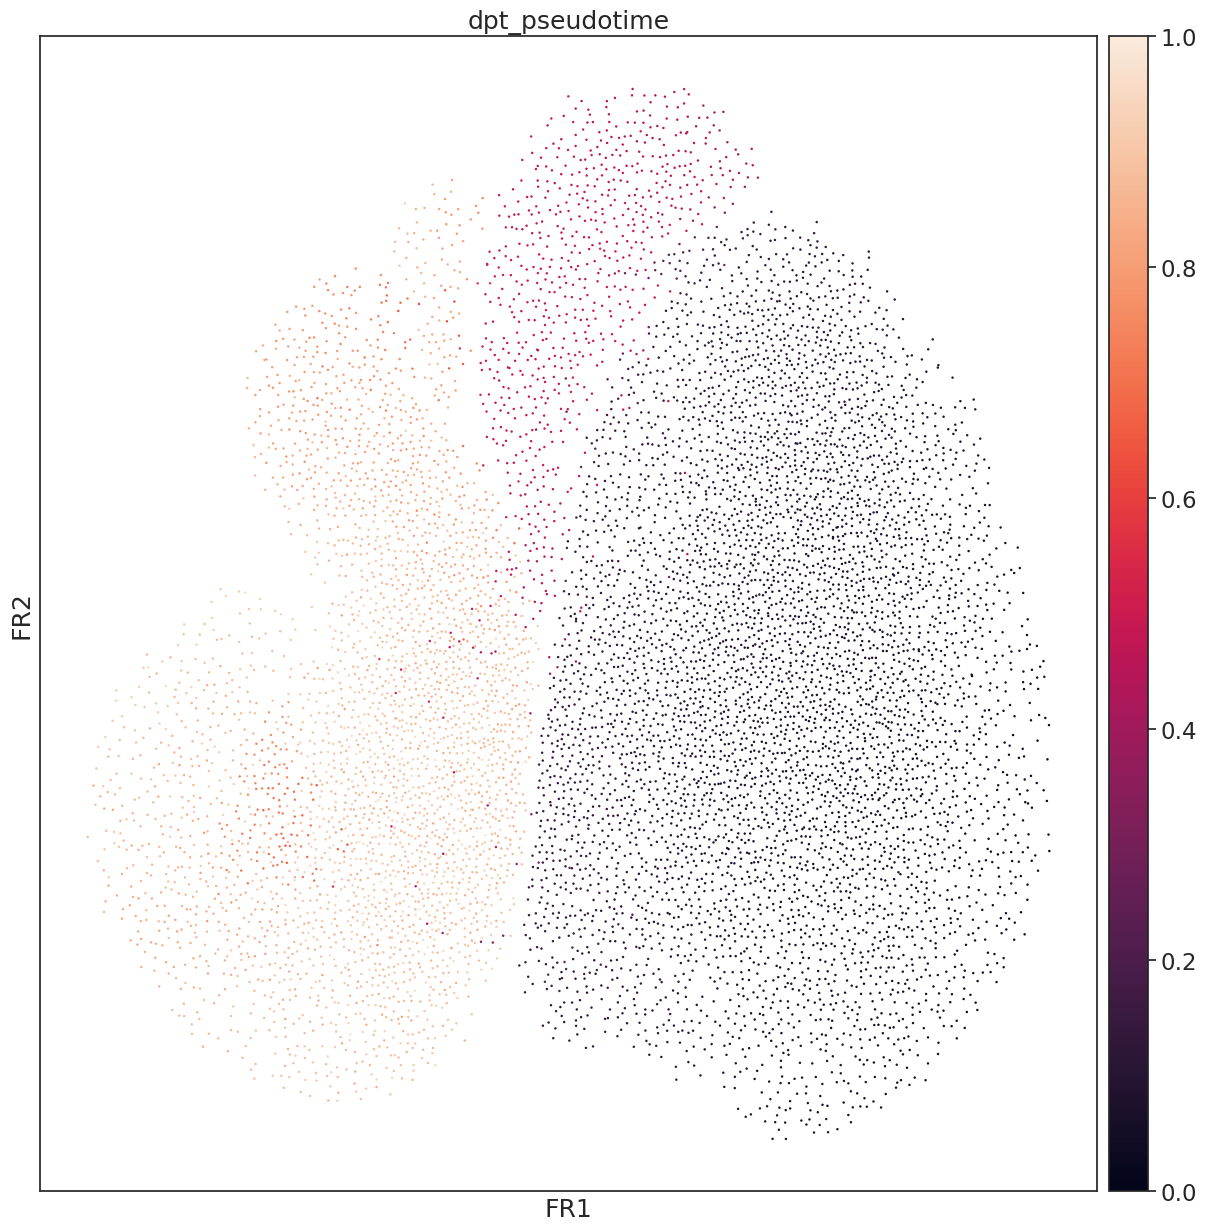

In [15]:
sc.pl.draw_graph(adata_pre_sub, color='dpt_pseudotime')

In [16]:
# multiome_rna=ad.read_h5ad('/data2/wangxuesong/benchmark_data/new_data/paired_unpaired/new_data/paired/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-RNA.h5ad')
multiome_rna=rna
bindsc_emb=ad.AnnData(pd.read_csv('/data2/wangxuesong/benchmark_data/benchmark_embedding/10x-Multiome-Pbmc10k-small/bindsc_rna.csv',header=None,index_col=0),obs=multiome_rna.obs)
Deepmaps_emb=ad.AnnData(pd.read_csv('/data2/wangxuesong/benchmark_data/benchmark_embedding/10x-Multiome-Pbmc10k-small/Deepmaps_rna.csv',header=None,index_col=0),obs=multiome_rna.obs)
GLUE_emb=ad.AnnData(pd.read_csv('/data2/wangxuesong/benchmark_data/benchmark_embedding/10x-Multiome-Pbmc10k-small/GLUE_rna.csv',header=None,index_col=0),obs=multiome_rna.obs)
iNMF_emb=ad.AnnData(pd.read_csv('/data2/wangxuesong/benchmark_data/benchmark_embedding/10x-Multiome-Pbmc10k-small/iNMF_rna.csv',header=None,index_col=0),obs=multiome_rna.obs)
LIGER_emb=ad.AnnData(pd.read_csv('/data2/wangxuesong/benchmark_data/benchmark_embedding/10x-Multiome-Pbmc10k-small/LIGER_rna.csv',header=None,index_col=0),obs=multiome_rna.obs)
MOFA_emb=ad.AnnData(pd.read_csv('/data2/wangxuesong/benchmark_data/benchmark_embedding/10x-Multiome-Pbmc10k-small/MOFA_rna.csv',header=None,index_col=0),obs=multiome_rna.obs)
Pamona_emb=ad.AnnData(pd.read_csv('/data2/wangxuesong/benchmark_data/benchmark_embedding/10x-Multiome-Pbmc10k-small/Pamona_rna.csv',header=None,index_col=0),obs=multiome_rna.obs)
PCA_emb=ad.AnnData(pd.read_csv('/data2/wangxuesong/benchmark_data/benchmark_embedding/10x-Multiome-Pbmc10k-small/PCA_rna.csv',header=None,index_col=0),obs=multiome_rna.obs)
scJoint_emb=ad.AnnData(pd.read_csv('/data2/wangxuesong/benchmark_data/benchmark_embedding/10x-Multiome-Pbmc10k-small/scJoint_rna.csv',header=None,index_col=0).values,obs=multiome_rna.obs)
scMDC_emb=ad.AnnData(pd.read_csv('/data2/wangxuesong/benchmark_data/benchmark_embedding/10x-Multiome-Pbmc10k-small/scMDC_rna.csv',header=None,index_col=0),obs=multiome_rna.obs)
scMoMaT_emb=ad.AnnData(pd.read_csv('/data2/wangxuesong/benchmark_data/benchmark_embedding/10x-Multiome-Pbmc10k-small/scMoMaT_rna.csv',header=None,index_col=0),obs=multiome_rna.obs)
scVI_emb=ad.AnnData(pd.read_csv('/data2/wangxuesong/benchmark_data/benchmark_embedding/10x-Multiome-Pbmc10k-small/scVI_rna.csv',header=None,index_col=0),obs=multiome_rna.obs)
seurat4_emb=ad.AnnData(pd.read_csv('/data2/wangxuesong/benchmark_data/benchmark_embedding/10x-Multiome-Pbmc10k-small/seurat4_rna.csv',header=None,index_col=0),obs=multiome_rna.obs)
seurat5_emb=ad.AnnData(pd.read_csv('/data2/wangxuesong/benchmark_data/benchmark_embedding/10x-Multiome-Pbmc10k-small/seurat5_rna.csv',header=None,index_col=0).values,obs=multiome_rna.obs)
TotalVI_emb=ad.AnnData(pd.read_csv('/data2/wangxuesong/benchmark_data/benchmark_embedding/10x-Multiome-Pbmc10k-small/TotalVI_rna.csv',header=None,index_col=0).values,obs=multiome_rna.obs)
Cobolt_emb=ad.AnnData(pd.read_csv('/data2/wangxuesong/benchmark_data/benchmark_embedding/10x-Multiome-Pbmc10k-small/Cobolt_rna.csv',header=None,index_col=0),obs=multiome_rna.obs)
MMD_MA_emb=ad.AnnData(pd.read_csv('/data2/wangxuesong/benchmark_data/benchmark_embedding/10x-Multiome-Pbmc10k-small/MMD_MA_rna.csv',header=None,index_col=0),obs=multiome_rna.obs)
UnionCom_emb=ad.AnnData(pd.read_csv('/data2/wangxuesong/benchmark_data/benchmark_embedding/10x-Multiome-Pbmc10k-small/UnionCom_rna.csv',header=None,index_col=0),obs=multiome_rna.obs)
UCE_emd=ad.AnnData(pd.read_csv('/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/UCE-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna.csv',header=None,index_col=0),obs=multiome_rna.obs)
Geneformer_emb=ad.AnnData(pd.read_csv('/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/Geneformer-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna.csv',header=None,index_col=0),obs=multiome_rna.obs)
scFoundation_emb=ad.AnnData(pd.read_csv('/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/scFoundation-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna.csv',header=None,index_col=0),obs=multiome_rna.obs)
scGPT_emb=ad.AnnData(pd.read_csv('/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/scGPT-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-smallbc-rna.csv',header=None,index_col=0),obs=multiome_rna.obs)
scGPT_zero_emb=ad.AnnData(pd.read_csv('/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/scGPT-zero-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-smallbc-rna.csv',header=None,index_col=0),obs=multiome_rna.obs)


In [17]:
# emb=[bindsc_emb,Deepmaps_emb,GLUE_emb,iNMF_emb,LIGER_emb,MOFA_emb,Pamona_emb,PCA_emb,scJoint_emb,scMDC_emb,scMoMaT_emb,scVI_emb,seurat4_emb,seurat5_emb,TotalVI_emb,Cobolt_emb,MMD_MA_emb,UnionCom_emb,UCE_emd,Geneformer_emb,scFoundation_emb,scGPT_emb,scGPT_zero_emb]
# titles=['bindSC','Deepmaps','GLUE','iNMF','LIGER','MOFA','Pamona','PCA','scJoint','scMDC','scMoMaT','scVI','Seurat4','Seurat5','TotalVI','Cobolt','MMD_MA','UnionCom','UCE','Geneformer','scFoundation','scGPT','scGPT_zero']

emb=[bindsc_emb
     ,PCA_emb
     ,scVI_emb
     ,scGPT_zero_emb
     ,scFoundation_emb
     ,UCE_emd
     ,Pamona_emb
     ,Geneformer_emb
     ,iNMF_emb
     ,scMoMaT_emb
     ,seurat5_emb
     ,GLUE_emb
     ,scGPT_emb
     ,scMDC_emb
     ,MMD_MA_emb
     ,Cobolt_emb
     ,MOFA_emb
     ,TotalVI_emb
     ,UnionCom_emb
     ,LIGER_emb
     ,Deepmaps_emb
     ,seurat4_emb
     ,scJoint_emb]

titles=['bindSC'
        ,'PCA'
        ,'scVI'
        ,'scGPT_zero'
        ,'scFoundation'
        ,'UCE'
        ,'Pamona'
        ,'Geneformer'
        ,'iNMF'
        ,'scMoMaT'
        ,'Seurat5'
        ,'GLUE'
        ,'scGPT'
        ,'scMDC'
        ,'MMD_MA'
        ,'Cobolt'
        ,'MOFA'
        ,'TotalVI'
        ,'UnionCom'
        ,'LIGER'
        ,'Deepmaps'
        ,'Seurat4'
        ,'scJoint']
scores=[0.862
        ,0.8513
        ,0.8174
        ,0.8159
        ,0.7793
        ,0.7709
        ,0.7395
        ,0.7304
        ,0.6982
        ,0.6777
        ,0.6724
        ,0.6616
        ,0.6469
        ,0.534
        ,0.4457
        ,0.362
        ,0.3223
        ,0.3071
        ,0.2785
        ,0.2435
        ,0.2053
        ,0.1343
        ,0.1333]
#tmp_emb=[scJoint_emb]
#tmp_titles=['scJoint']

In [18]:
multiome_rna

AnnData object with n_obs × n_vars = 9631 × 8000
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'dpt_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'tag', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'pca', 'neighbors', 'iroot', 'diffmap_evals'
    obsm: 'X_pca', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [19]:
sc.pp.pca(multiome_rna)
#sc.tl.draw_graph(rna)
sc.pp.neighbors(multiome_rna)
indices = np.where(np.array(multiome_rna.obs['cell_type'] == 'HSPC'))[0]
    #rna.uns["iroot"] = np.random.choice(indices)
multiome_rna.uns["iroot"] = indices[1]

sc.tl.diffmap(multiome_rna)
#sc.pp.neighbors(rna,use_rep='X_diffmap')
sc.tl.dpt(multiome_rna)

In [20]:
all_dpt=[]
for idx,i in enumerate(emb):
    print(idx)
    sc.pp.pca(i)
#sc.tl.draw_graph(emb_rna)
    sc.pp.neighbors(i)
    adata_pre_sub, adata_post_sub=trajectory_plot(multiome_rna,i,"cell_type","embed")
    all_dpt.append(adata_post_sub)
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [21]:
all_dpt[0]

AnnData object with n_obs × n_vars = 9631 × 15
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'dpt_pseudotime', 'neighborhood', 'dpt_after'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

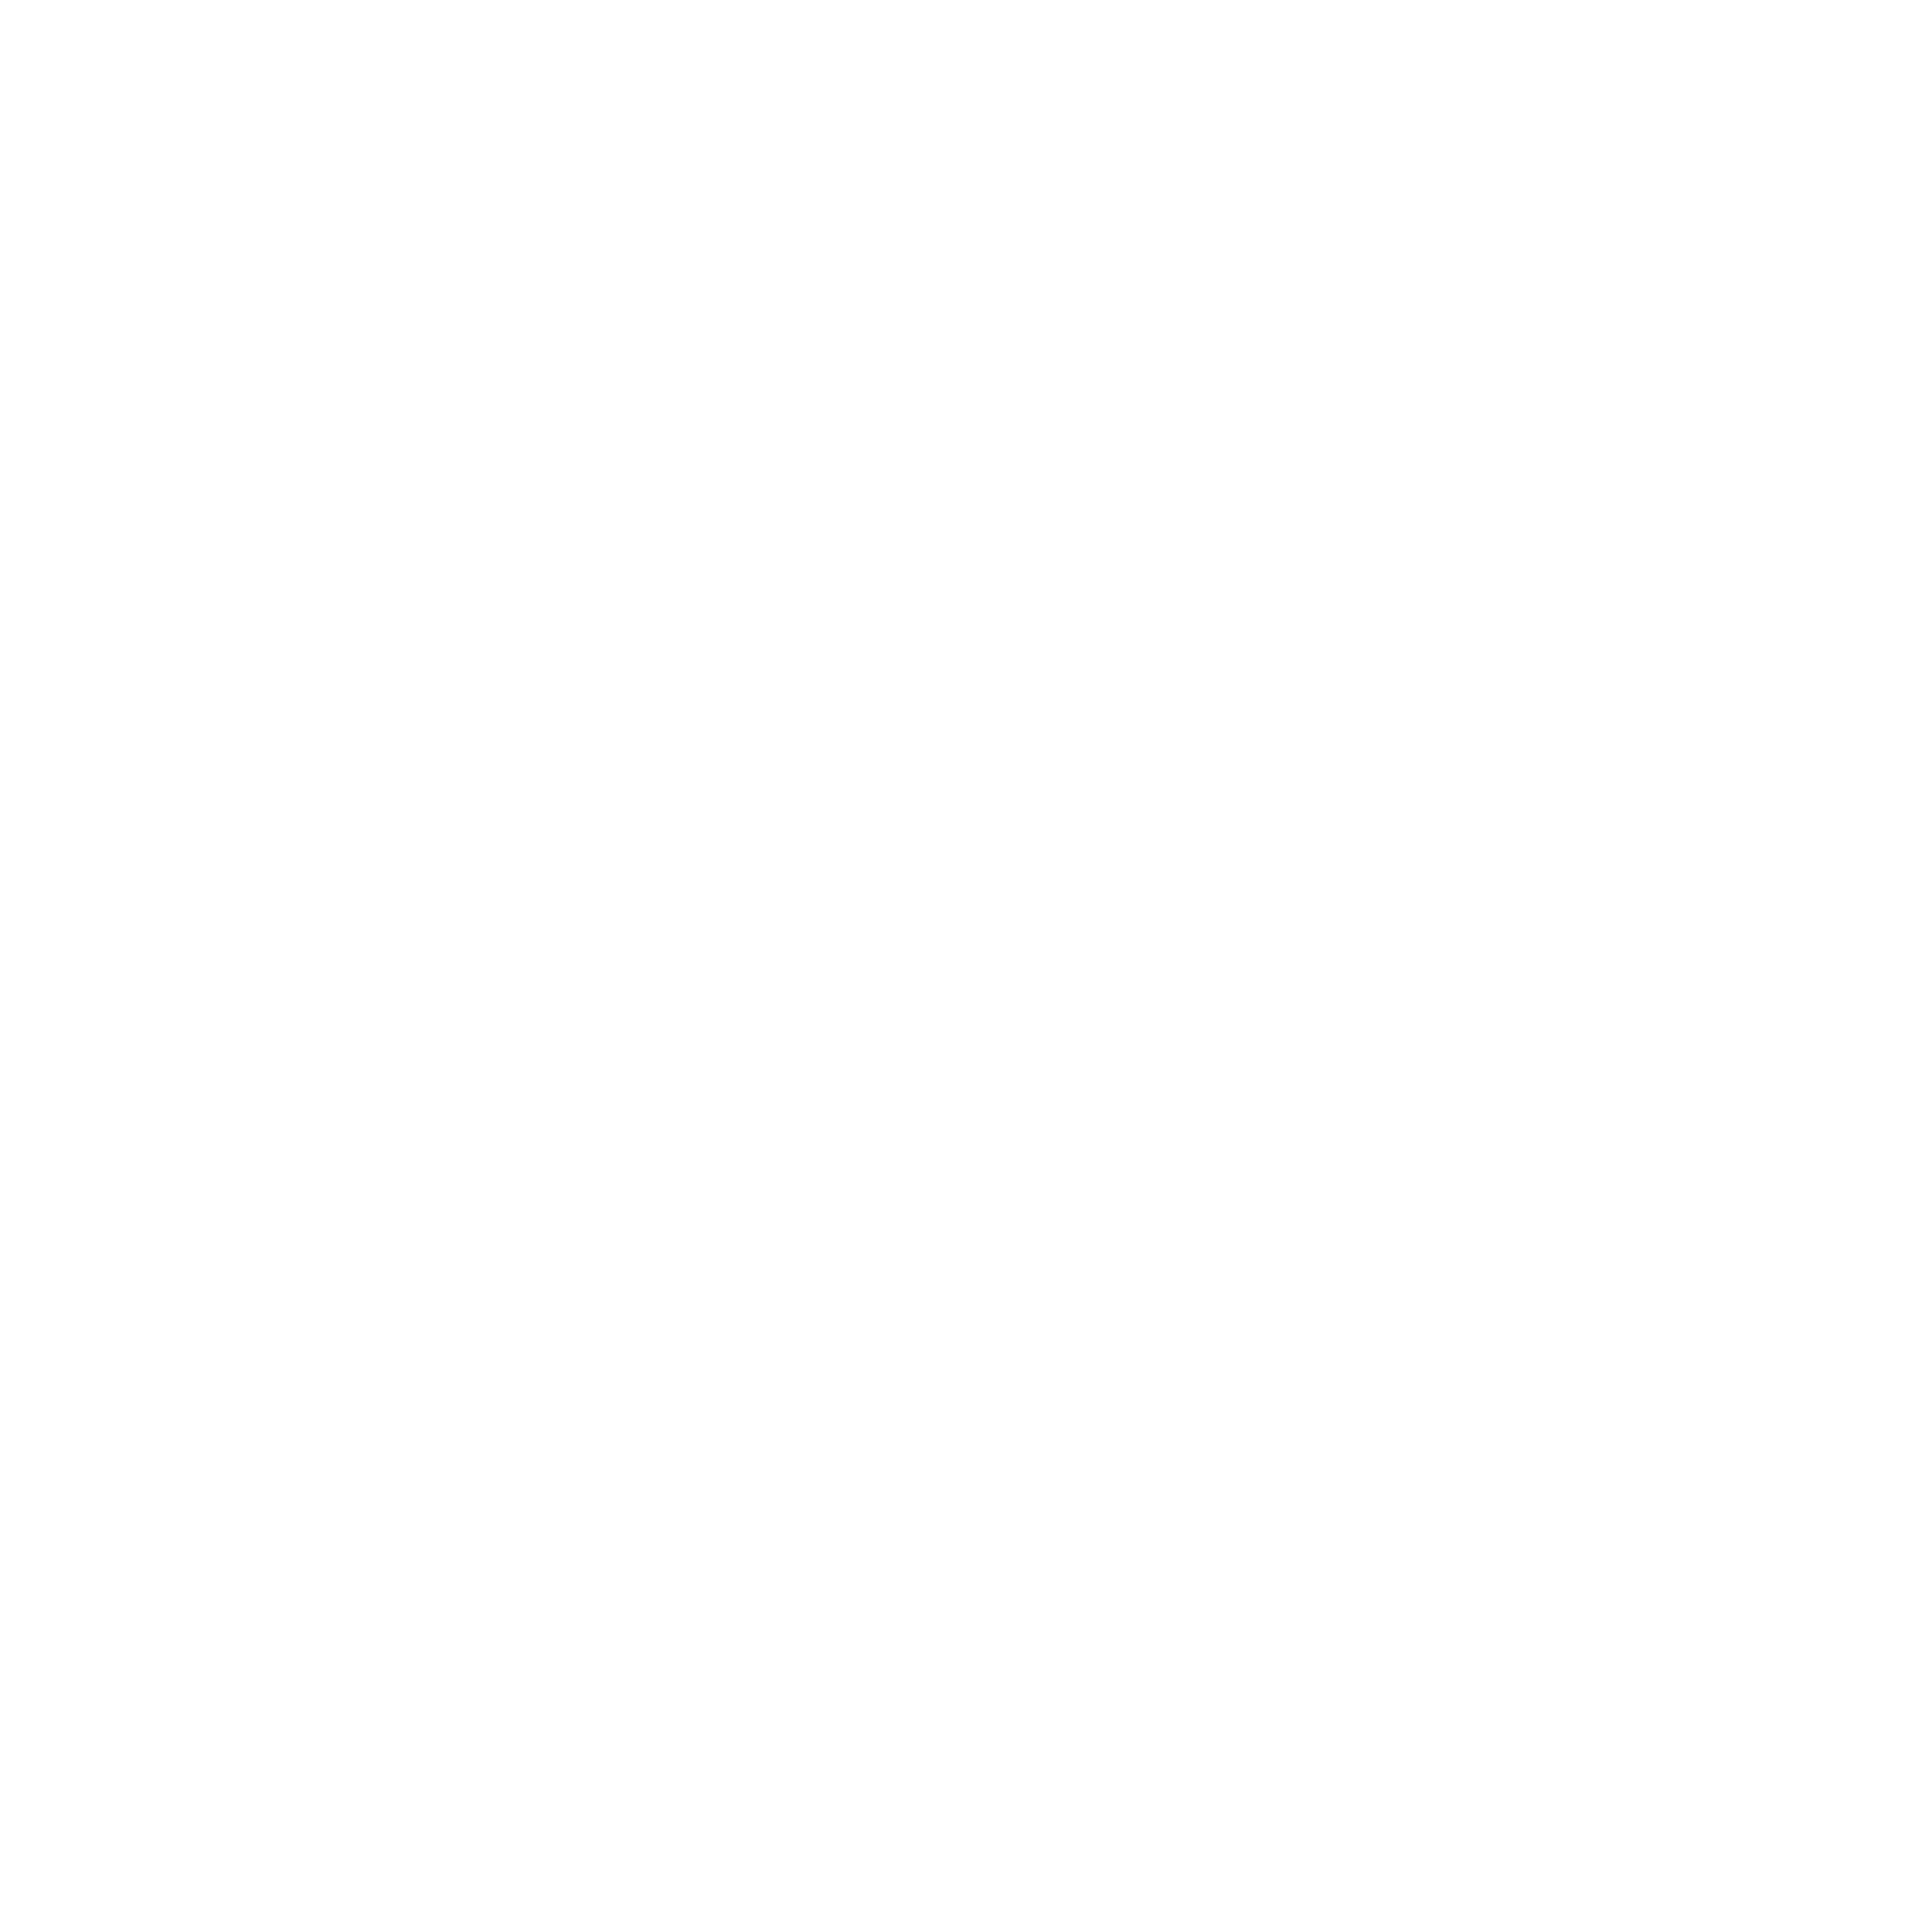

In [27]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))
for ax in axes.flatten():
    ax.axis('off')

In [28]:
j=0
umap=[]
sc.tl.umap(adata_pre_sub)
umap.append(adata_pre_sub)
for idx,i in enumerate(all_dpt):
    
    sc.tl.umap(i)
    umap.append(i)
   #  if idx%4==0:
   #     j=j+1
   #  sc.pl.umap(i, color='dpt_after', title='UMAP', show=False, frameon=False, ax=axes[j,idx%4])
    

In [29]:
j=0
for idx,i in enumerate(umap):    
    if idx%5==0:
        j=j+1
    if idx==0:
        sc.pl.umap(i, color='dpt_pseudotime',title='Groud Truth',show=False, frameon=False, ax=axes[j-1,idx%5])
    else:
        sc.pl.umap(i, color='dpt_after',title=titles[idx-1]+',TC='+str(scores[idx-1]),show=False, frameon=False, ax=axes[j-1,idx%5])
        # axes[j-1, idx % 5].annotate('Annotation', (1, 1), textcoords="offset points", xytext=(0,10), ha='center')
    

<Figure size 1500x1500 with 0 Axes>

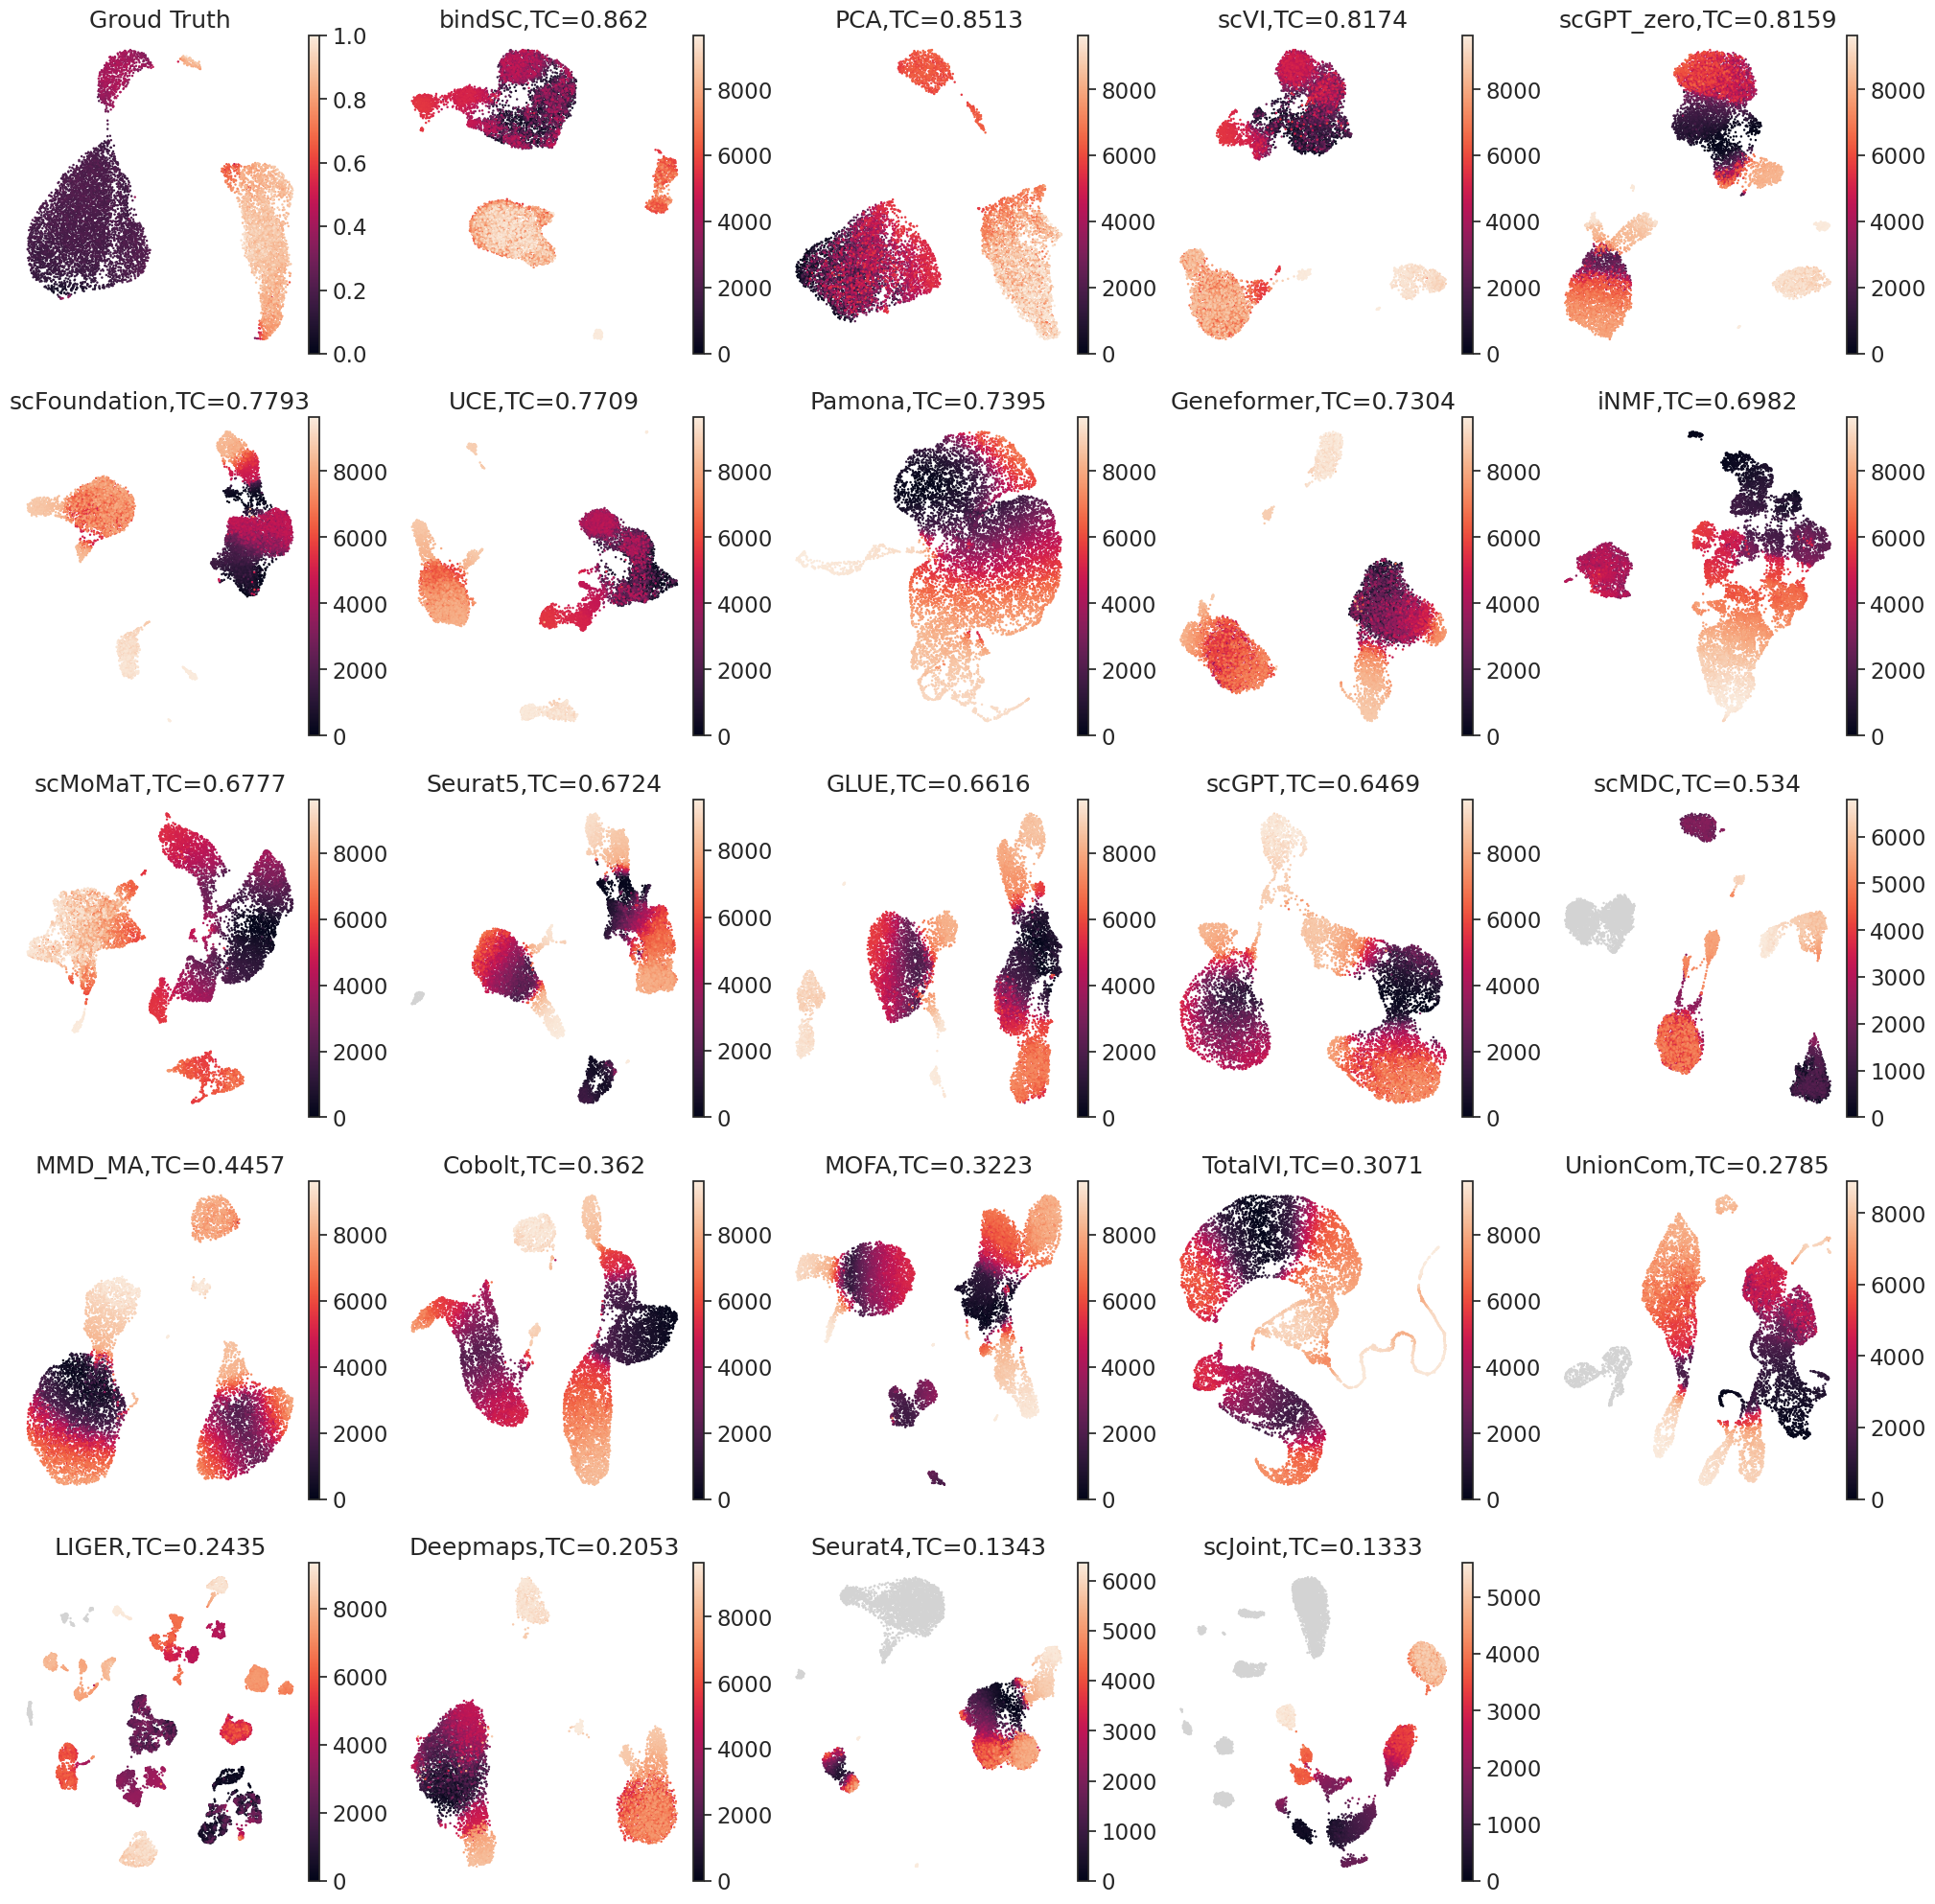

In [30]:
fig

In [32]:
fig.savefig('/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/graphs/10x_bc.png',dpi=400)

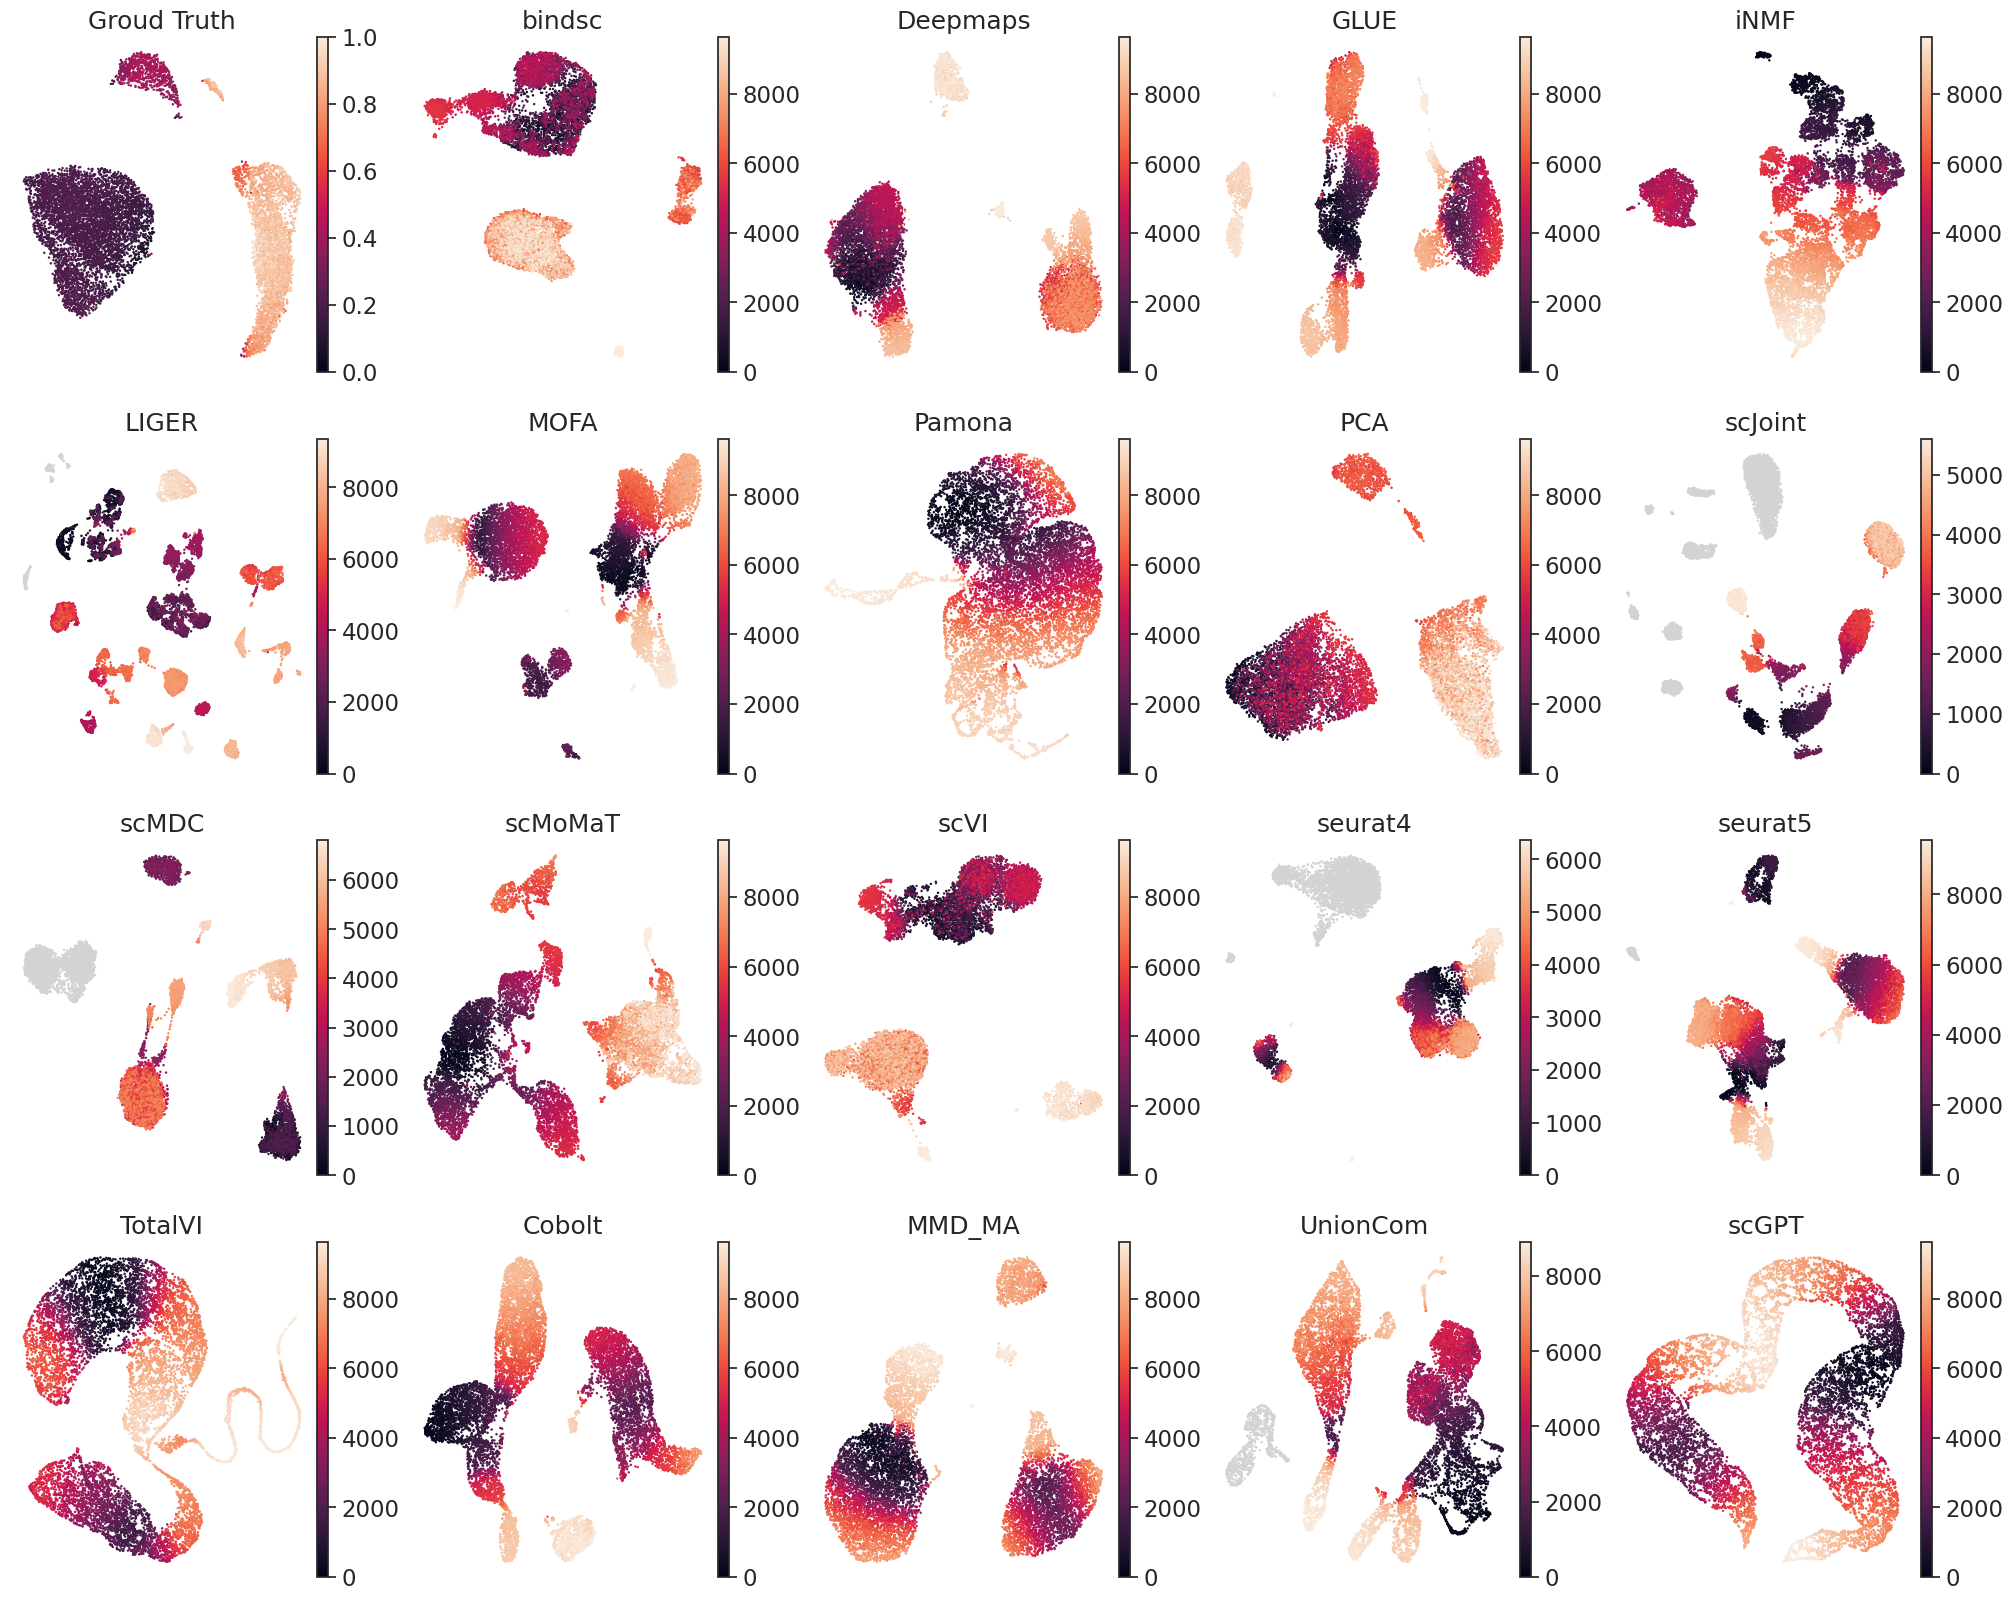

In [42]:
plt.savefig('traj_output.png')

<Figure size 1500x1500 with 0 Axes>

<Axes: title={'center': 'Groudtruth'}, xlabel='UMAP1', ylabel='UMAP2'>

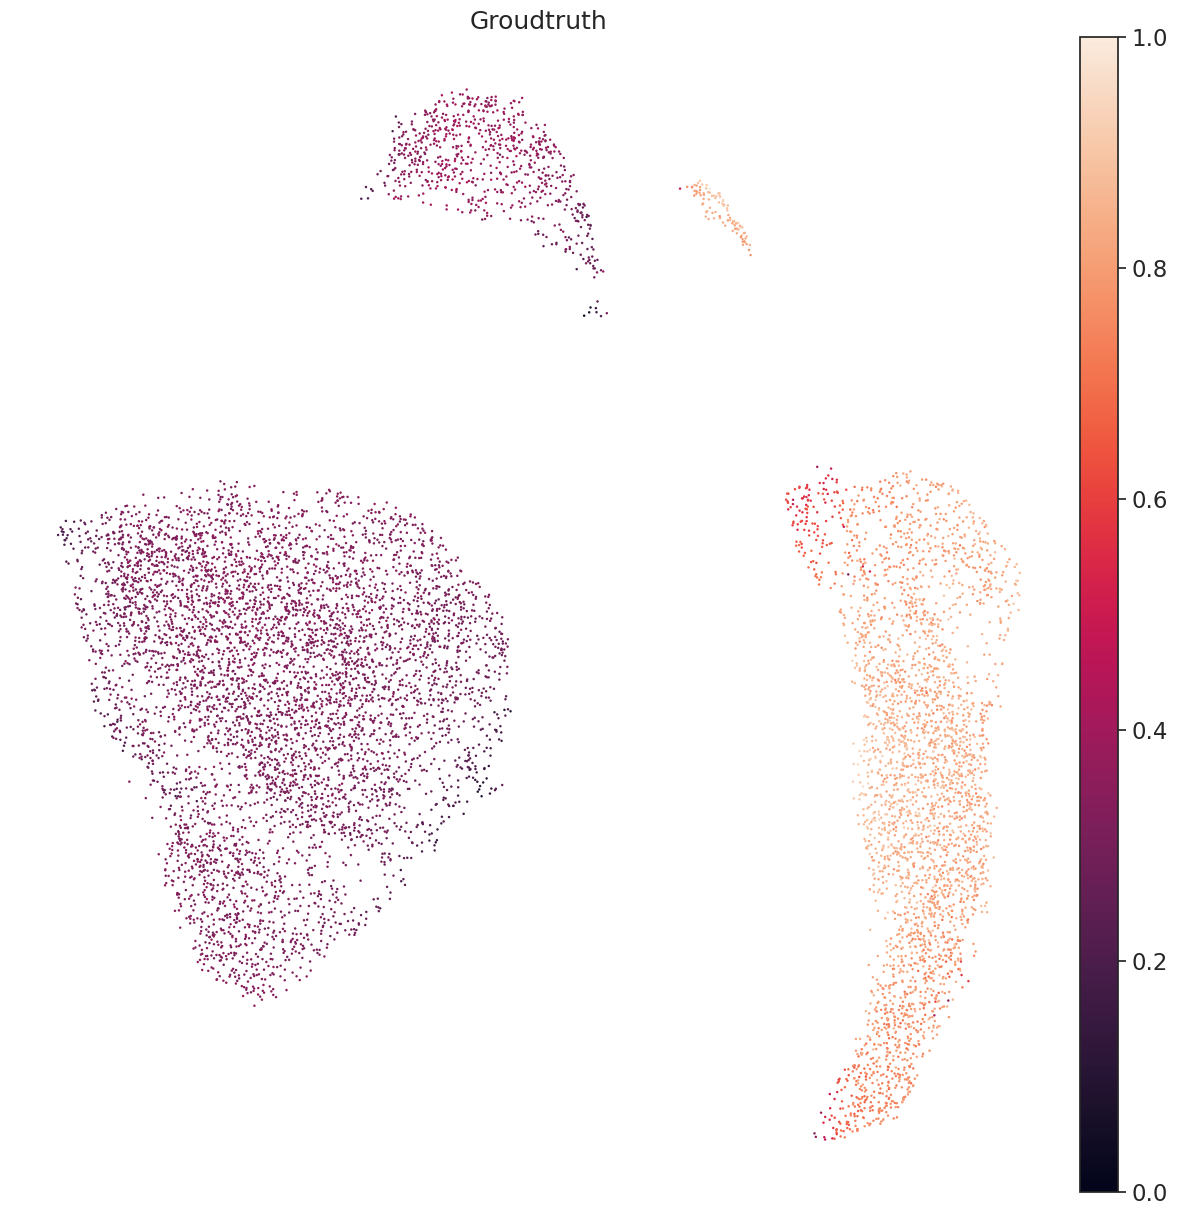

In [51]:
import warnings

warnings.filterwarnings('ignore')
sc.tl.umap(adata_pre_sub)
sc.pl.umap(adata_pre_sub, color='dpt_pseudotime', title='Groudtruth', show=False, frameon=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import gridspec

In [ ]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
ax0.plot(x, y)
ax1 = plt.subplot(gs[1])
ax1.plot(y, x)


In [1]:
import numpy as np

In [38]:
A=np.array([[1,0.5,3,0.33,0.5,0.33],[2,1,5,0.5,0.33,0.25],[0.33,0.2,7,1.0,2,0.33],[3,2,7,1,2,0.33],[2,3,5,0.5,1,0.33],[3,4,7,3,3,1]])

In [32]:
def compute(A):
    M=A/np.sum(A,axis=0)
    W=[]
    for i in M:
        #print(i)
        tmp=1
        for j in i:
            tmp=tmp*j
        W.append(np.power(tmp, 1/len(i)))
    RI=[0.0,0.0,0.58,0.90,1.12,1.24,1.32,1.41,1.45]
    tmp=A.dot(np.transpose(np.array(W)))
    lam=np.sum(tmp/np.array(W))/tmp.shape[0]
    CI=(lam-tmp.shape[0])/(tmp.shape[0]-1)
    CR=CI/RI[tmp.shape[0]-1]
    print("一致性比例%f"%(CR))
    print("lammax%f"%(lam))
    for idx,i in enumerate(W):
        print("F%d权重%f"%(idx,i))
    return CR
    
    

In [39]:
compute(A)

一致性比例0.570294
lammax9.535823
F0权重0.071881
F1权重0.094154
F2权重0.089529
F3权重0.189846
F4权重0.142463
F5权重0.329373


0.5702939735850461

In [8]:
M=A/np.sum(A,axis=0)
M

array([[0.16666667, 0.11111111, 0.19879518],
       [0.33333333, 0.22222222, 0.19879518],
       [0.5       , 0.66666667, 0.60240964]])

In [14]:
W=[]
for i in M:
    #print(i)
    tmp=1
    for j in i:
        tmp=tmp*j
    W.append(np.power(tmp, 1/len(i)))
W
    

[0.15440831984787462, 0.24510792935915837, 0.5855853714981755]

In [18]:
RI=[0.0,0.0,0.58,0.90,1.12,1.24,1.32,1.41,1.45]
tmp=A.dot(np.transpose(np.array(W)))
lam=np.sum(tmp/np.array(W))/tmp.shape[0]
CI=(lam-tmp.shape[0])/(tmp.shape[0]-1)
CR=CI/RI[tmp.shape[0]-1]

0.02338044103600434